In [3]:
from mvpa2.suite import *
verbose.level = 2

### Path to tutorial data

In [4]:
# put your filepath in here!
filepath = '/Users/vassiki/Desktop/brainhack'

verbose(1, "Loading data...")
filename = 'hyperalignment_tutorial_data_2.4.hdf5.gz'
fn = os.path.join(filepath,filename)
ds_all = h5load(fn)

 Loading data...


In [20]:
type(ds_all)

list

### Load and describe data

In [5]:
# zscore all datasets individually
_ = [zscore(ds) for ds in ds_all]
# inject the subject ID into all datasets
for i, sd in enumerate(ds_all):
    sd.sa['subject'] = np.repeat(i, len(sd))
# number of subjects
nsubjs = len(ds_all)
# number of categories
ncats = len(ds_all[0].UT)
# number of run
nruns = len(ds_all[0].UC)
verbose(2, "%d subjects" % len(ds_all))
verbose(2, "Per-subject dataset: %i samples with %i features" % ds_all[0].shape)
verbose(2, "Stimulus categories: %s" % ', '.join(ds_all[0].UT))

  10 subjects
  Per-subject dataset: 56 samples with 3509 features
  Stimulus categories: Chair, DogFace, FemaleFace, House, MaleFace, MonkeyFace, Shoe


### Linear SVM, feature selection with one-way ANOVA

In [6]:
clf = LinearCSVMC()

# feature selection helpers
nf = 100
fselector = FixedNElementTailSelector(nf, tail='upper',
                                      mode='select', sort=False)
sbfs = SensitivityBasedFeatureSelection(OneWayAnova(), fselector,
                                        enable_ca=['sensitivities'])
# create classifier with automatic feature selection
fsclf = FeatureSelectionClassifier(clf, sbfs)

### Within subject classification, leave one run out CV

In [7]:
verbose(1, "Performing classification analyses...")
verbose(2, "within-subject...", cr=False, lf=False)
wsc_start_time = time.time()
cv = CrossValidation(fsclf,
                     NFoldPartitioner(attr='chunks'),
                     errorfx=mean_match_accuracy)
# store results in a sequence
wsc_results = [cv(sd) for sd in ds_all]
wsc_results = vstack(wsc_results)
verbose(2, " done in %.1f seconds" % (time.time() - wsc_start_time,))

 Performing classification analyses...
  within-subject... done in 1.7 seconds


### Between subject classification, anatomically aligned

In [8]:
verbose(2, "between-subject (anatomically aligned)...", cr=False, lf=False)
ds_mni = vstack(ds_all)
mni_start_time = time.time()
cv = CrossValidation(fsclf,
                     NFoldPartitioner(attr='subject'),
                     errorfx=mean_match_accuracy)
bsc_mni_results = cv(ds_mni)
verbose(2, "done in %.1f seconds" % (time.time() - mni_start_time,))

  between-subject (anatomically aligned)...done in 0.8 seconds


### Hyperalignment!!! 

In [9]:
verbose(2, "between-subject (hyperaligned)...", cr=False, lf=False)
hyper_start_time = time.time()
bsc_hyper_results = []
# same cross-validation over subjects as before
cv = CrossValidation(clf, NFoldPartitioner(attr='subject'),
                     errorfx=mean_match_accuracy)

# leave-one-run-out for hyperalignment training
for test_run in range(nruns):
    # split in training and testing set
    ds_train = [sd[sd.sa.chunks != test_run, :] for sd in ds_all]
    ds_test = [sd[sd.sa.chunks == test_run, :] for sd in ds_all]

    # manual feature selection for every individual dataset in the list
    anova = OneWayAnova()
    fscores = [anova(sd) for sd in ds_train]
    featsels = [StaticFeatureSelection(fselector(fscore)) for fscore in fscores]
    ds_train_fs = [fs.forward(sd) for fs, sd in zip(featsels, ds_train)]


    # Perform hyperalignment on the training data with default parameters.
    # Computing hyperalignment parameters is as simple as calling the
    # hyperalignment object with a list of datasets. All datasets must have the
    # same number of samples and time-locked responses are assumed.
    # Hyperalignment returns a list of mappers corresponding to subjects in the
    # same order as the list of datasets we passed in.


    hyper = Hyperalignment()
    hypmaps = hyper(ds_train_fs)

    # Applying hyperalignment parameters is similar to applying any mapper in
    # PyMVPA. We start by selecting the voxels that we used to derive the
    # hyperalignment parameters. And then apply the hyperalignment parameters
    # by running the test dataset through the forward() function of the mapper.

    ds_test_fs = [fs.forward(sd) for fs, sd in zip(featsels, ds_test)]
    ds_hyper = [h.forward(sd) for h, sd in zip(hypmaps, ds_test_fs)]

    # Now, we have a list of datasets with feature correspondence in a common
    # space derived from the training data. Just as in the between-subject
    # analyses of anatomically aligned data we can stack them all up and run the
    # crossvalidation analysis.

    ds_hyper = vstack(ds_hyper)
    # zscore each subject individually after transformation for optimal
    # performance
    zscore(ds_hyper, chunks_attr='subject')
    res_cv = cv(ds_hyper)
    bsc_hyper_results.append(res_cv)

bsc_hyper_results = hstack(bsc_hyper_results)
verbose(2, "done in %.1f seconds" % (time.time() - hyper_start_time,))

  between-subject (hyperaligned)...done in 3.6 seconds


### Performance Comparison

In [10]:
verbose(1, "Average classification accuracies:")
verbose(2, "within-subject: %.2f +/-%.3f"
        % (np.mean(wsc_results),
           np.std(wsc_results) / np.sqrt(nsubjs - 1)))
verbose(2, "between-subject (anatomically aligned): %.2f +/-%.3f"
        % (np.mean(bsc_mni_results),
           np.std(np.mean(bsc_mni_results, axis=1)) / np.sqrt(nsubjs - 1)))
verbose(2, "between-subject (hyperaligned): %.2f +/-%.3f" \
        % (np.mean(bsc_hyper_results),
           np.std(np.mean(bsc_hyper_results, axis=1)) / np.sqrt(nsubjs - 1)))

 Average classification accuracies:
  within-subject: 0.57 +/-0.063
  between-subject (anatomically aligned): 0.42 +/-0.035
  between-subject (hyperaligned): 0.63 +/-0.046


### Exploring similarity structures

In [11]:
# feature selection as above
anova = OneWayAnova()
fscores = [anova(sd) for sd in ds_all]
fscores = np.mean(np.asarray(vstack(fscores)), axis=0)
# apply to full datasets
ds_fs = [sd[:, fselector(fscores)] for sd in ds_all]
#run hyperalignment on full datasets
hyper = Hyperalignment()
mappers = hyper(ds_fs)
ds_hyper = [m.forward(ds_) for m, ds_ in zip(mappers, ds_fs)]
# similarity of original data samples
sm_orig = [np.corrcoef(
               sd.get_mapped(
                   mean_group_sample(['targets'])).samples)
                       for sd in ds_fs]
# mean across subjects
sm_orig_mean = np.mean(sm_orig, axis=0)
# same individual average but this time for hyperaligned data
sm_hyper_mean = np.mean(
    [np.corrcoef(
        sd.get_mapped(mean_group_sample(['targets'])).samples)
     for sd in ds_hyper],
    axis=0)
# similarity for averaged hyperaligned data
ds_hyper = vstack(ds_hyper)
sm_hyper = np.corrcoef(ds_hyper.get_mapped(mean_group_sample(['targets'])))
# similarity for averaged anatomically aligned data
ds_fs = vstack(ds_fs)
sm_anat = np.corrcoef(ds_fs.get_mapped(mean_group_sample(['targets'])))

In [13]:
%matplotlib inline

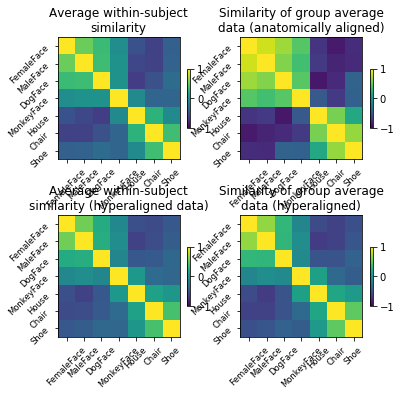

In [14]:
intended_label_order = [2, 4, 1, 5, 3, 0, 6]
labels = ds_all[0].UT
labels = labels[intended_label_order]

pl.figure(figsize=(6, 6))
# plot all three similarity structures
for i, sm_t in enumerate((
    (sm_orig_mean, "Average within-subject\nsimilarity"),
    (sm_anat, "Similarity of group average\ndata (anatomically aligned)"),
    (sm_hyper_mean, "Average within-subject\nsimilarity (hyperaligned data)"),
    (sm_hyper, "Similarity of group average\ndata (hyperaligned)"),
    )):
    sm, title = sm_t
    # reorder matrix columns to match label order
    sm = sm[intended_label_order][:, intended_label_order]
    pl.subplot(2, 2, i + 1)
    pl.imshow(sm, vmin=-1.0, vmax=1.0, interpolation='nearest')
    pl.colorbar(shrink=.4, ticks=[-1, 0, 1])
    pl.title(title, size=12)
    ylim = pl.ylim()
    pl.xticks(range(ncats), labels, size='small', stretch='ultra-condensed',
              rotation=45)
    pl.yticks(range(ncats), labels, size='small', stretch='ultra-condensed',
              rotation=45)
    pl.ylim(ylim)

### Regularized Hyperalignment

In [15]:
alpha_levels = np.concatenate((np.linspace(0.0, 0.7, 8),
                               np.linspace(0.8, 1.0, 5)))
# to collect the results for later visualization
bsc_hyper_results = np.zeros((nsubjs, len(alpha_levels), nruns))
# same cross-validation over subjects as before
cv = CrossValidation(clf, NFoldPartitioner(attr='subject'),
                     errorfx=mean_match_accuracy)

# leave-one-run-out for hyperalignment training
for test_run in range(nruns):
    # split in training and testing set
    ds_train = [sd[sd.sa.chunks != test_run, :] for sd in ds_all]
    ds_test = [sd[sd.sa.chunks == test_run, :] for sd in ds_all]

    # manual feature selection for every individual dataset in the list
    anova = OneWayAnova()
    fscores = [anova(sd) for sd in ds_train]
    featsels = [StaticFeatureSelection(fselector(fscore)) for fscore in fscores]
    ds_train_fs = [featsels[i].forward(sd) for i, sd in enumerate(ds_train)]

    for alpha_level, alpha in enumerate(alpha_levels):
        hyper = Hyperalignment(alignment=ProcrusteanMapper(svd='dgesvd',
                                                           space='commonspace'),
                               alpha=alpha)
        hypmaps = hyper(ds_train_fs)
        ds_test_fs = [fs.forward(sd) for fs, sd in zip(featsels, ds_test)]
        ds_hyper = [h.forward(sd) for h, sd in zip(hypmaps, ds_test_fs)]
        ds_hyper = vstack(ds_hyper)
        zscore(ds_hyper, chunks_attr='subject')
        res_cv = cv(ds_hyper)
        bsc_hyper_results[:, alpha_level, test_run] = res_cv.samples.T

 * Please note: warnings are printed only once, but underlying problem might occur many times *


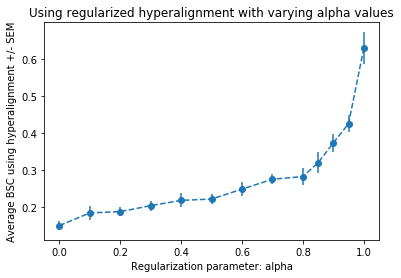

In [16]:
bsc_hyper_results = np.mean(bsc_hyper_results, axis=2)
pl.figure()
plot_err_line(bsc_hyper_results, alpha_levels)
pl.xlabel('Regularization parameter: alpha')
pl.ylabel('Average BSC using hyperalignment +/- SEM')
pl.title('Using regularized hyperalignment with varying alpha values')

### Searchlight Hyperalignment

In [17]:
verbose(1, "Performing classification analyses...")
verbose(2, "between-subject (searchlight hyperaligned)...", cr=False, lf=False)
# feature selection helpers
slhyper_start_time = time.time()
bsc_slhyper_results = []
# same cross-validation over subjects as before
cv = CrossValidation(clf, NFoldPartitioner(attr='subject'),
                     errorfx=mean_match_accuracy)

# leave-one-run-out for hyperalignment training
for test_run in range(nruns):
    # split in training and testing set
    ds_train = [sd[sd.sa.chunks != test_run, :] for sd in ds_all]
    ds_test = [sd[sd.sa.chunks == test_run, :] for sd in ds_all]

    # Initializing Searchlight Hyperalignment with Sphere searchlights of 3 voxel radius.
    # Using 40% features in each SL and spacing centers at 3-voxels distance.
    slhyper = SearchlightHyperalignment(radius=3, featsel=0.4, sparse_radius=3)

    # Performing searchlight hyperalignment on training data.
    # This step is similar to regular hyperalignment, calling
    # the searchlight hyperalignment object with a list of datasets.
    # Searchlight Hyperalignment returns a list of mappers corresponding to
    # subjects in the same order as the list of datasets we passed in.
    slhypmaps = slhyper(ds_train)

    # Applying hyperalignment parameters is similar to applying any mapper in
    # PyMVPA. We apply the hyperalignment parameters by running the test dataset
    # through the forward() function of the mapper.
    ds_hyper = [h.forward(sd) for h, sd in zip(slhypmaps, ds_test)]

    # Running between-subject classification as before.
    ds_hyper = vstack(ds_hyper)
    zscore(ds_hyper, chunks_attr='subject')
    res_cv = cv(ds_hyper)
    bsc_slhyper_results.append(res_cv)

bsc_slhyper_results = hstack(bsc_slhyper_results)
verbose(2, "done in %.1f seconds" % (time.time() - slhyper_start_time,))

 Performing classification analyses...
  between-subject (searchlight hyperaligned)...WARNING: Using 0th dataset as the reference dataset (0th after excluding datasets)
done in 316.3 seconds


### Compare Performance

In [18]:
verbose(1, "Average classification accuracies:")
verbose(2, "between-subject (searchlight hyperaligned): %.2f +/-%.3f" \
        % (np.mean(bsc_slhyper_results),
           np.std(np.mean(bsc_slhyper_results, axis=1)) / np.sqrt(nsubjs - 1)))

 Average classification accuracies:
  between-subject (searchlight hyperaligned): 0.60 +/-0.032
